# ⚡ XGBoost Models for Drug Sensitivity Prediction

This notebook trains an **XGBoost regression model per drug** using gene expression features. XGBoost is widely used for structured data due to its speed, regularization, and strong predictive performance. We use **5-fold cross-validation** to evaluate model generalization with both RMSE and R² scores.


In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
NUM_PCS = 20

# Choose your dataset (PCA or HVG)
DATA_PATH = "../../../data/bulk/bulk_with_pca.parquet"
data = pd.read_parquet(DATA_PATH)

print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (571985, 23)


### 🔁 Train One XGBoost Model Per Drug

For each drug, we train a separate XGBoost regressor using its associated (cell line, IC50, features) data. Performance is evaluated using RMSE and R².


In [3]:
os.makedirs("xgb/models", exist_ok=True)
os.makedirs("xgb/results", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        print(f"⚠️ Skipping drug {drug_id} (samples: {df.shape[0]})")
        continue

    X = df[gene_cols].values
    y = df["LN_IC50"].values

    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        n_jobs=-1,
        random_state=42,
        verbosity=0
    )

    rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

    print(f"\n💊 Drug {drug_id} | Samples: {len(df)}")
    print(f"  ➤ RMSE (folds): {(-rmse_scores).round(4)} | Mean: {-rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"  ➤ R²   (folds): {r2_scores.round(4)} | Mean: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })

    model.fit(X, y)
    joblib.dump(model, f"xgb/models/xgb_drug_{drug_id}.pkl")



💊 Drug 1 | Samples: 391
  ➤ RMSE (folds): [1.3694 0.9695 0.9328 1.2906 1.1381] | Mean: 1.1401 ± 0.1717
  ➤ R²   (folds): [-0.2791 -0.0125 -0.2644  0.0533  0.0284] | Mean: -0.0949 ± 0.1460

💊 Drug 3 | Samples: 356
  ➤ RMSE (folds): [2.3342 1.9235 2.1452 1.8514 2.201 ] | Mean: 2.0911 ± 0.1787
  ➤ R²   (folds): [-0.1535 -0.1718 -0.008  -0.1783 -0.0619] | Mean: -0.1147 ± 0.0678

💊 Drug 5 | Samples: 394
  ➤ RMSE (folds): [1.5634 1.4372 1.6623 1.5075 1.6172] | Mean: 1.5575 ± 0.0794
  ➤ R²   (folds): [0.1026 0.0854 0.0547 0.2414 0.0219] | Mean: 0.1012 ± 0.0753

💊 Drug 6 | Samples: 403
  ➤ RMSE (folds): [0.9345 1.1414 0.9652 0.88   0.8846] | Mean: 0.9611 ± 0.0956
  ➤ R²   (folds): [-0.1964 -0.2407 -0.2116 -0.2007 -0.055 ] | Mean: -0.1809 ± 0.0648

💊 Drug 9 | Samples: 396
  ➤ RMSE (folds): [1.5136 1.3324 1.2616 1.7037 1.6086] | Mean: 1.4840 ± 0.1656
  ➤ R²   (folds): [-0.0443  0.0587  0.0969 -0.1721 -0.1555] | Mean: -0.0433 ± 0.1088

💊 Drug 11 | Samples: 393
  ➤ RMSE (folds): [2.1689 2.1209 1.

In [5]:
results_df = pd.DataFrame(results)
results_df.to_csv(f"xgb/results/model_performance_summary_{NUM_PCS}_pcs.csv", index=False)

print("📁 Saved to xgb/results/model_performance_summary.csv")
results_df.head()


📁 Saved to xgb/results/model_performance_summary.csv


,DRUG_ID,n_samples,rmse_mean,rmse_std,r2_mean,r2_std
0,1,391,1.140082,0.171653,-0.094851,0.146015
1,3,356,2.091060,0.178719,-0.114701,0.067794
2,5,394,1.557511,0.079430,0.101168,0.075322
3,6,403,0.961136,0.095551,-0.180894,0.064794
4,9,396,1.483971,0.165591,-0.043285,0.108850


### 📊 Distribution of XGBoost Model Performance

These plots visualize the RMSE and R² across all drug-specific models trained using XGBoost.


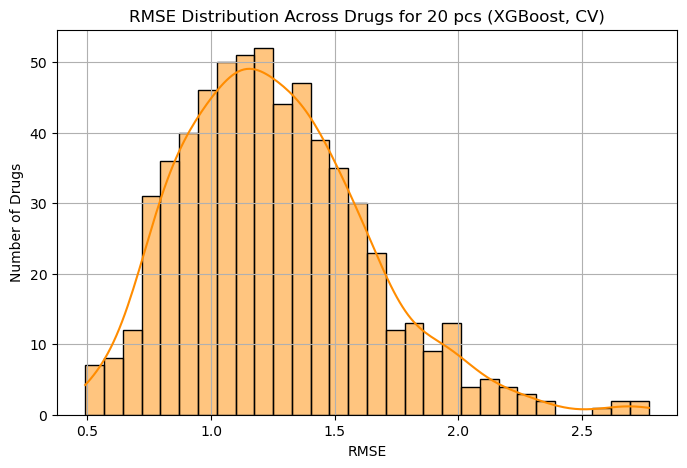

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title(f"RMSE Distribution Across Drugs for {NUM_PCS} pcs (XGBoost, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"xgb/results/rmse_comparison_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()

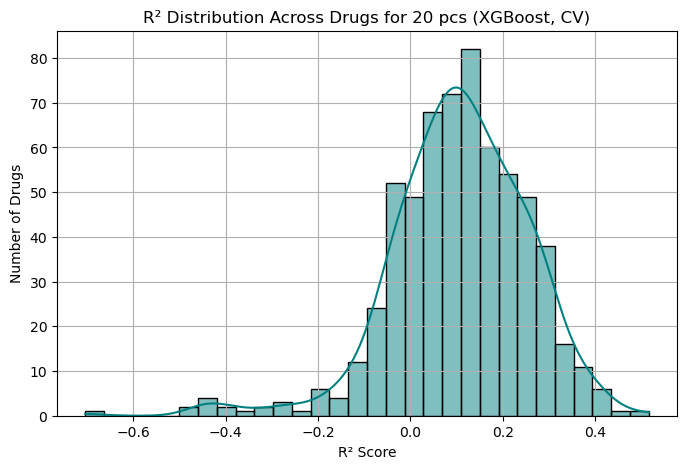

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title(f"R² Distribution Across Drugs for {NUM_PCS} pcs (XGBoost, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"xgb/results/r2_comparison_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()